# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

#### Описание проекта <br> 
**Заказчик этого исследования — сеть отелей `«Как в гостях»`.**<br> 
 Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. <br> 
 Однако если клиент отменял бронирование, то компания терпела убытки. <br> 
 Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони.<br> 
 Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — `80%` от стоимости номера за одни сутки и затрат на `разовую уборку`.

In [1]:
!pip install -U imbalanced-learn


     |████████████████████████████████| 226 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 71.9 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
! conda update -n base conda

In [ ]:
!conda install -c conda-forge imbalanced-learn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.2
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    imbalanced-learn-0.7.0     |             py_1          97 KB  conda-forge
    joblib-1.2.0               |     pyhd8ed1ab_0         205 KB  conda-forge
    scikit-learn-0.24.2        |   py39h4dfa638_0         7.6 MB  conda-forge
    scipy-1.6.3                |   py39hee8e79c_0        20.7 MB  conda-forge
    threadpoolctl-3.1.0        |     pyh8a188c0_0          18 KB  conda-forge
    -

In [3]:
# импортируем необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,roc_auc_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [4]:
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

In [5]:
# бюджет на разработку модели
BUDJET = 4E5

### Шаг 1. Откройте файлы с данными

In [6]:
try:
    df_test = pd.read_csv(r'D:\Сборный проект №2\hotel_test.csv')
    df_train = pd.read_csv(r'D:\Сборный проект №2\hotel_train.csv')
except:
    df_test = pd.read_csv('/datasets/hotel_test.csv')
    df_train = pd.read_csv('/datasets/hotel_train.csv')

In [7]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

(None, None)

* Обучающий датасет содержит **65229** наблюдений, а тестовый датасет содержит **32412** наблюдений.
* Обучающий датасет имеет **25** признаков и тестовый датасет имеет **25** признаков.
* Признак `is_canceled` в обучающем и тестовом датасетах целевой.

In [8]:
def concat_df(train, test):
    # Возвращает объединенный df обучающего и тестового датасета
    return pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Возвращает разделенные df обучающего и тестового датасета
    return all_data.loc[:65228], all_data.loc[65229:]

df_all = concat_df(df_train, df_test)


print('Размерность тренировочного датасета = {}\n'.format(df_train.shape))
print('Размерность тестового датасета = {}\n'.format(df_test.shape))
print('Размерность объединенного датасета = {}\n'.format(df_all.shape))
print(df_train.columns)
print(df_test.columns)
print(df_all.columns)      

Размерность тренировочного датасета = (65229, 25)

Размерность тестового датасета = (32412, 25)

Размерность объединенного датасета = (97641, 25)

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object')
Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country

In [9]:
df_all.head()

,adults,arrival_date_day_of_month,arrival_date_month,arrival_date_week_number,arrival_date_year,babies,booking_changes,children,country,customer_type,days_in_waiting_list,distribution_channel,id,is_canceled,is_repeated_guest,lead_time,meal,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,reserved_room_type,stays_in_week_nights,stays_in_weekend_nights,total_nights,total_of_special_requests
0,1.0,1,July,27,2015,0.0,0,0.0,GBR,Transient,0,Direct,0,0,0,7.0,BB,0,0,0,A,1,0,1,0
1,2.0,1,July,27,2015,0.0,0,0.0,GBR,Transient,0,TA/TO,1,0,0,14.0,BB,0,0,0,A,2,0,2,1
2,2.0,1,July,27,2015,0.0,0,0.0,PRT,Transient,0,Direct,2,0,0,0.0,BB,0,0,0,C,2,0,2,0
3,2.0,1,July,27,2015,0.0,0,0.0,PRT,Transient,0,Direct,3,0,0,9.0,FB,0,0,0,C,2,0,2,1
4,2.0,1,July,27,2015,0.0,0,0.0,PRT,Transient,0,TA/TO,4,1,0,85.0,BB,0,0,0,A,3,0,3,1


In [10]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97641 entries, 0 to 97640
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   adults                          97641 non-null  float64
 1   arrival_date_day_of_month       97641 non-null  int64  
 2   arrival_date_month              97641 non-null  object 
 3   arrival_date_week_number        97641 non-null  int64  
 4   arrival_date_year               97641 non-null  int64  
 5   babies                          97641 non-null  float64
 6   booking_changes                 97641 non-null  int64  
 7   children                        97641 non-null  float64
 8   country                         97641 non-null  object 
 9   customer_type                   97641 non-null  object 
 10  days_in_waiting_list            97641 non-null  int64  
 11  distribution_channel            97641 non-null  object 
 12  id                              

### Шаг 2. Предобработка и исследовательский анализ данных

#### Изменение типа данных

In [11]:
df_all[['adults','children','babies','lead_time']] = df_all[['adults','children','babies','lead_time']].astype('int64')

Данные в этих колонках не могут быть дробными, поэтому поменял тип на `int`.

#### Поиск дубликатов.

In [12]:
print(df_all.duplicated().sum())

0


Явных дубликатов не обнаружено.

#### Наличие пропусков в ячейках.

In [13]:
df_all.isna().sum()

adults                            0
arrival_date_day_of_month         0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_year                 0
babies                            0
booking_changes                   0
children                          0
country                           0
customer_type                     0
days_in_waiting_list              0
distribution_channel              0
id                                0
is_canceled                       0
is_repeated_guest                 0
lead_time                         0
meal                              0
previous_bookings_not_canceled    0
previous_cancellations            0
required_car_parking_spaces       0
reserved_room_type                0
stays_in_week_nights              0
stays_in_weekend_nights           0
total_nights                      0
total_of_special_requests         0
dtype: int64

Пропущенных данных в ячейках нет.

In [14]:
df_all = df_all.drop('id', axis = 1)

Удалим столбец `id`, так как в дальнейшем он не пригодится для обучения модели.

#### Была проведена проверка уникальных значений во всех столбцах с типом `object`. По итогу проведена корректировка значений в столбцах `meal`,`reserved_room_type`.

In [15]:
df_all['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [16]:
df_all['meal'] = df_all['meal'].str.strip()

In [17]:
df_all['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [18]:
df_all['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [19]:
df_all['reserved_room_type'] = df_all['reserved_room_type'].str.strip()

In [20]:
df_all['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

#### В нашем датафрейме большое количество столбцов.Посмотрим каждый из них, сгруппируем данные внутри столбцов где это возможно.<br>
#### Посмотрим распределения целевого признака относительно значений в колонках. Оставим только необходимые колонки.

* Характеристики даты.*

In [21]:
df_all['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [22]:
# Сгруппируем данные по временам года.
df_all['arrival_date_month'] = df_all['arrival_date_month'].replace(['December','January', 'February'],'winter')
df_all['arrival_date_month'] = df_all['arrival_date_month'].replace(['March', 'April', 'May'],'spring')
df_all['arrival_date_month'] = df_all['arrival_date_month'].replace(['June','July', 'August'],'summer')
df_all['arrival_date_month'] = df_all['arrival_date_month'].replace(['September', 'October', 'November'],'autumn')

In [23]:
df_all['arrival_date_month'].unique()

array(['summer', 'autumn', 'winter', 'spring'], dtype=object)

* Время года `arrival_date_month`.*

Text(0, 0.5, 'Количество заказов')

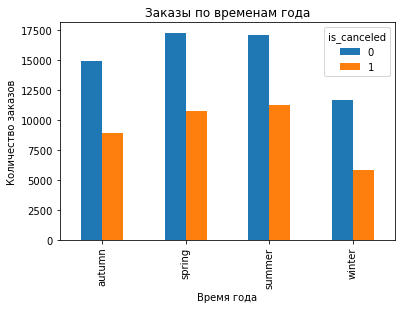

In [24]:
%matplotlib inline
pd.crosstab(df_all.arrival_date_month, df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы по временам года')
plt.xlabel('Время года')
plt.ylabel('Количество заказов')

* Количество взрослых `adults`

In [25]:
df_all.adults.unique()

array([1, 2, 3, 4, 0], dtype=int64)

In [26]:
pd.crosstab(df_all.adults,df_all.is_canceled)

is_canceled,0,1
adults,,
0,156,79
1,13600,5892
2,44166,29051
3,3068,1607
4,16,6


Text(0, 0.5, 'Количество заказов')

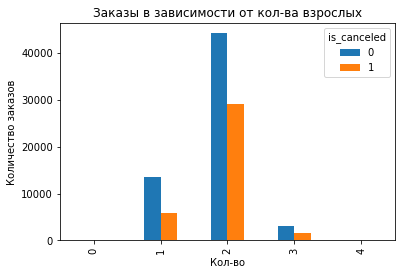

In [27]:
%matplotlib inline
pd.crosstab(df_all.adults,df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы в зависимости от кол-ва взрослых')
plt.xlabel('Кол-во')
plt.ylabel('Количество заказов')

In [28]:
df_all.query('adults ==0 & babies != 0')

,adults,arrival_date_day_of_month,arrival_date_month,arrival_date_week_number,arrival_date_year,babies,booking_changes,children,country,customer_type,days_in_waiting_list,distribution_channel,is_canceled,is_repeated_guest,lead_time,meal,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,reserved_room_type,stays_in_week_nights,stays_in_weekend_nights,total_nights,total_of_special_requests
22534,0,18,winter,51,2015,1,0,2,PRT,Transient-Party,0,TA/TO,0,0,6,BB,0,0,0,B,1,0,1,2
44049,0,9,winter,50,2015,1,1,2,PRT,Transient,0,Direct,1,0,22,BB,0,0,0,B,4,1,5,1
52923,0,9,summer,24,2016,1,2,2,ITA,Transient,0,TA/TO,0,0,14,BB,0,0,0,B,3,0,3,2


In [29]:
df_all.query('adults ==0 & children != 0').head()

,adults,arrival_date_day_of_month,arrival_date_month,arrival_date_week_number,arrival_date_year,babies,booking_changes,children,country,customer_type,days_in_waiting_list,distribution_channel,is_canceled,is_repeated_guest,lead_time,meal,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,reserved_room_type,stays_in_week_nights,stays_in_weekend_nights,total_nights,total_of_special_requests
17540,0,10,summer,33,2015,0,1,3,PRT,Transient-Party,0,Direct,0,0,1,BB,0,0,0,B,1,1,2,0
17598,0,11,summer,33,2015,0,1,2,FRA,Transient-Party,0,TA/TO,0,0,104,BB,0,0,0,B,3,0,3,2
17982,0,16,summer,34,2015,0,1,2,PRT,Transient-Party,0,Direct,0,0,3,BB,0,0,0,B,0,2,2,1
21556,0,19,autumn,43,2015,0,0,2,PRT,Transient-Party,0,TA/TO,1,0,48,BB,0,0,0,B,3,1,4,1
22516,0,13,winter,51,2015,0,0,3,PRT,Transient-Party,0,TA/TO,1,0,6,BB,0,0,0,B,0,1,1,1


Так как без взрослых номер сдать не могут, то удалим эти данные. В идеал надо уточнить их у коллег, проверить выгрузку.

In [30]:
df_all = df_all.query('adults != 0')

* Порядковый номер дня в месяце `arrival_date_day_of_month`.

In [31]:
df_all.arrival_date_day_of_month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

Text(0, 0.5, 'Количество заказов')

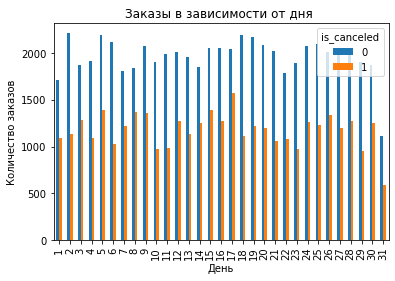

In [32]:
%matplotlib inline
pd.crosstab(df_all.arrival_date_day_of_month,df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы в зависимости от дня ')
plt.xlabel('День')
plt.ylabel('Количество заказов')

Эту колонку уберем из итогового датафрейма для модели, то в какой день сделан заказ не влияет на итоговый отказ от брони.

* Порядковый номер недели в году `arrival_date_week_number`.

Text(0, 0.5, 'Количество заказов')

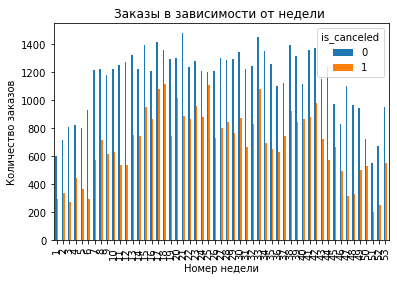

In [33]:
%matplotlib inline
pd.crosstab(df_all.arrival_date_week_number,df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы в зависимости от недели ')
plt.xlabel('Номер недели')
plt.ylabel('Количество заказов')

Эту колонку уберем из итогового датафрейма для модели, порядковый номер недели не влияет на отказ от брони.

* Год `arrival_date_year`

In [34]:
df_all.arrival_date_year.unique()

array([2015, 2016, 2017], dtype=int64)

Text(0, 0.5, 'Количество заказов')

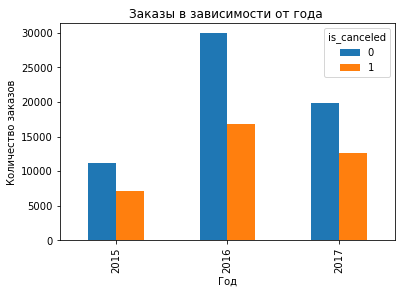

In [35]:
%matplotlib inline
pd.crosstab(df_all.arrival_date_year,df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы в зависимости от года ')
plt.xlabel('Год')
plt.ylabel('Количество заказов')

Эту колонку уберем из итогового датафрейма для модели, прошлые года никак не спрогнозируют нам будущее.

* Количество детей `babies`.

In [36]:
df_all.babies.unique()

array([ 0,  1,  2, 10,  9], dtype=int64)

Text(0, 0.5, 'Количество заказов')

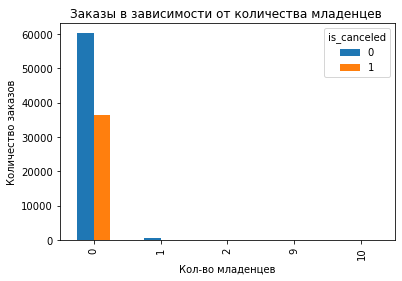

In [37]:
%matplotlib inline
pd.crosstab(df_all.babies,df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы в зависимости от количества младенцев ')
plt.xlabel('Кол-во младенцев')
plt.ylabel('Количество заказов')

In [38]:
pd.crosstab(df_all.babies,df_all.is_canceled)

is_canceled,0,1
babies,,
0,60330,36452
1,511,104
2,7,0
9,1,0
10,1,0


Здесь значения `9` и `10` явно являются выбросами.<br>
В остальном же не видно зависимости, что количество младенцев влияет на отказ от брони.

Эту колонку уберем из итогового датафрейма для модели.

* Количество изменений в заказе`booking_changes` .

In [39]:
df_all.booking_changes.unique()

array([ 0,  1,  3,  2,  4,  5,  6, 10, 16,  7,  9, 13,  8, 14, 15, 17, 18,
       11], dtype=int64)

Text(0, 0.5, 'Количество заказов')

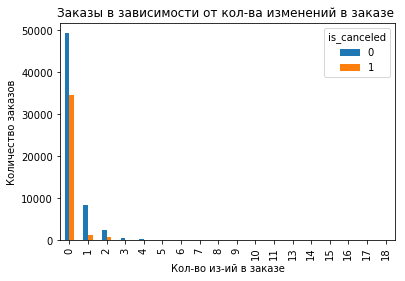

In [40]:
%matplotlib inline
pd.crosstab(df_all.booking_changes,df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы в зависимости от кол-ва изменений в заказе ')
plt.xlabel('Кол-во из-ий в заказе')
plt.ylabel('Количество заказов')

In [41]:
pd.crosstab(df_all.booking_changes,df_all.is_canceled)

is_canceled,0,1
booking_changes,,
0,49336,34442
1,8337,1296
2,2285,615
3,561,111
4,212,54
5,54,15
6,20,15
7,20,2
8,6,2


Практически все заказы были оформлены без внесение изменений. Можно было бы предположить, что имеются какие-то технические проблемы при оформлении (н-р неправильно сохраняются введенные данные) из-за кторой нужно вносить изменения, это в итоге раздражает людей и они отменяют бронь. Но по данным этого не скажешь, есть дынные где имеется 15 изменений, но отказа нет.

Эту колонку уберем из итогового датафрейма для модели.

* Количество деетей `children`.

In [42]:
df_all.children.unique()

array([0, 1, 2, 3], dtype=int64)

Text(0, 0.5, 'Количество заказов')

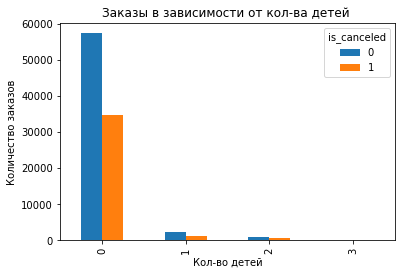

In [43]:
%matplotlib inline
pd.crosstab(df_all.children,df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы в зависимости от кол-ва детей ')
plt.xlabel('Кол-во детей')
plt.ylabel('Количество заказов')

In [44]:
pd.crosstab(df_all.children,df_all.is_canceled)

is_canceled,0,1
children,,
0,57344,34706
1,2428,1127
2,1071,719
3,7,4


Для каждого значения в колонке с кол-вом детей примерно половина отказов.<br>
Уберем из итогового датафрейма.

* Страна `country`.

In [45]:
df_all.country.unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

In [46]:
pd.crosstab(df_all.country,df_all.is_canceled)

is_canceled,0,1
country,,
ABW,2,0
AGO,123,80
ALB,10,1
AND,0,2
ARE,4,32
...,...,...
VGB,0,1
VNM,6,2
ZAF,42,27


* Тип заказчика `customer_type`.

In [47]:
df_all.customer_type.unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

Text(0, 0.5, 'Количество заказов')

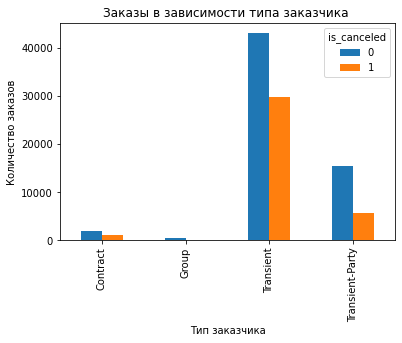

In [48]:
%matplotlib inline
pd.crosstab(df_all.customer_type,df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы в зависимости типа заказчика ')
plt.xlabel('Тип заказчика')
plt.ylabel('Количество заказов')

* Сколько дней заказ ожидал подтверждения `days_in_waiting_list`.

In [49]:
df_all.days_in_waiting_list.unique()

array([  0,  50,  47,  65, 122,  75, 101, 150, 125,  22, 142,   2,  13,
        44,  38,  48,  33,  77,  21,  80,  59,  40,  58,  89,  53,  49,
        60,  69,  87,  91,  57,  99, 111,  79,  98,  85,  63,  15,   3,
        20,  93,   4,  41,  34, 224,  31,  39,  56, 187, 176,  71,  55,
        96, 236, 259, 207, 215, 160, 120,  30,  32,  27,  62,  24, 108,
       147,   5,  14, 107,  70,   8,  35, 178, 174, 162,  68,  11, 193,
        10,  76,  17,  45,   6,  19,  28,  42,  25,  46,   9,   1,  43,
        72,  12,  61,  81,  74, 167, 100, 121,  83, 113,  18, 185, 109,
       154,  64,  16, 165,   7,  84, 175, 183,  23, 117,  54,  26,  73,
       223, 105,  36], dtype=int64)

In [50]:
pd.crosstab(df_all.days_in_waiting_list, df_all.is_canceled)

is_canceled,0,1
days_in_waiting_list,,
0,59674,34331
1,5,1
2,3,1
3,0,59
4,17,8
...,...,...
215,8,13
223,1,0
224,4,6


Подтверждение происходит уже после оформления и внесения депозита, если это необходимо.<br>
Уберем эту колонку из итогового датафрейма.

* Канал дистрибуции `distribution_channel`.

In [51]:
df_all.distribution_channel.unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [52]:
pd.crosstab(df_all.distribution_channel,df_all.is_canceled)

is_canceled,0,1
distribution_channel,,
Corporate,4182,1241
Direct,8660,1805
GDS,151,33
TA/TO,47857,33477


Text(0, 0.5, 'Количество заказов')

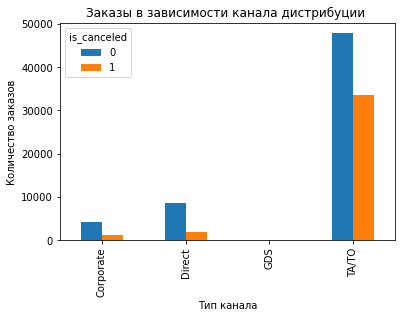

In [53]:
%matplotlib inline
pd.crosstab(df_all.distribution_channel,df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы в зависимости канала дистрибуции ')
plt.xlabel('Тип канала')
plt.ylabel('Количество заказов')

* Повторное офрмление заказа `is_repeated_guest`.

In [54]:
df_all.is_repeated_guest.unique()

array([0, 1], dtype=int64)

Text(0, 0.5, 'Количество заказов')

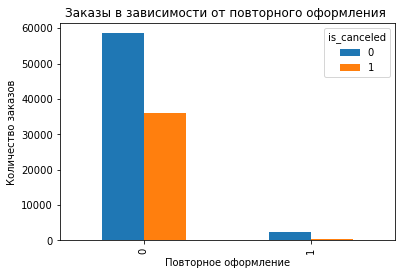

In [55]:
%matplotlib inline
pd.crosstab(df_all.is_repeated_guest,df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы в зависимости от повторного оформления ')
plt.xlabel('Повторное оформление')
plt.ylabel('Количество заказов')

In [56]:
pd.crosstab(df_all.is_repeated_guest,df_all.is_canceled)

is_canceled,0,1
is_repeated_guest,,
0,58561,36060
1,2289,496


* Количество дней между бронью и заездом `lead_time`.

In [57]:
df_all.lead_time.unique()

array([  7,  14,   0,   9,  85,  75,  23,  18,  68,  37,  72,  48,  77,
        99,  40,  15,  36,  70,  45,  16, 107,  47,  96, 113,  50,   3,
         1,  10,   5,  17,  93,  71,  63,  62, 101,   2,  81,  12, 109,
       102,   4,  92,  95,  86,  78,  29,  30,  51,  33,   8, 100,  80,
        97,  64,  90,  27,  82,  94, 115, 111,  98,  66, 104,  65,  55,
        21,  88,  43,  54, 280,  24, 103, 249,  13,  79,  35,  31,  34,
        44, 304, 117,  84, 110,  59, 116,  91,  42,  60, 321,  32,  56,
        41,  76,  49,  73, 112,  39,  58,  57,  19,  53,  38,   6, 108,
        26, 123,  28, 118,  46,  69,  52,  89,  61,  22,  67, 105,  25,
        11,  87, 299,  74, 298, 119,  20,  83, 136, 129, 124, 130, 131,
       139, 122, 106, 137, 120, 135, 150, 143, 151, 126, 147, 128, 156,
       132, 164, 159, 161, 333, 149, 154, 297, 163, 314, 323, 340, 142,
       302, 175, 166, 114, 140, 157, 310, 172, 145, 121, 127, 178, 152,
       158, 125, 185, 177, 165, 200, 192, 174, 134, 350, 283, 16

In [58]:
pd.crosstab(df_all.lead_time,df_all.is_canceled)

is_canceled,0,1
lead_time,,
0,4472,320
1,2494,269
2,1478,169
3,1304,147
4,1243,141
...,...,...
367,2,20
368,7,29
372,0,44


Уберем из итогового датафрейма, для прогноза отмена брони эти данные не нужны, так как предложение внести депозит идет раньше по временой шкале чем отсчет дней до заезда.

* Опции заказа `meal`.

In [59]:
df_all.meal.unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

Text(0, 0.5, 'Количество заказов')

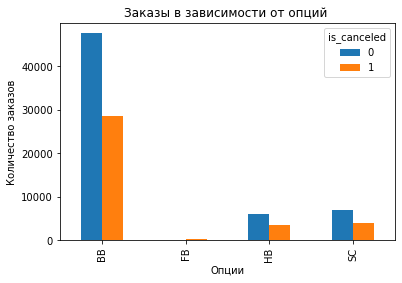

In [60]:
%matplotlib inline
pd.crosstab(df_all.meal,df_all.is_canceled).plot(kind = 'bar')
plt.title('Заказы в зависимости от опций ')
plt.xlabel('Опции')
plt.ylabel('Количество заказов')

* Количество подтвержденных заказов у клиента `previous_bookings_not_canceled`.

In [61]:
df_all.previous_bookings_not_canceled.unique()

array([ 0,  1,  2,  3,  4,  5,  6, 10, 12, 13, 15, 21,  7,  9,  8, 11, 14,
       18, 22, 16, 17, 19, 20, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 25, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72], dtype=int64)

In [62]:
pd.crosstab(df_all.previous_bookings_not_canceled,df_all.is_canceled)

is_canceled,0,1
previous_bookings_not_canceled,,
0,58410,36406
1,1008,59
2,389,24
3,212,11
4,164,9
...,...,...
68,1,0
69,1,0
70,1,0


* Количество отмененнных заказов у клиента `previous_cancellations`.

In [63]:
df_all.previous_cancellations.unique()

array([ 0,  1,  2,  3, 26, 25, 14, 24, 19,  4,  5, 21,  6, 13, 11],
      dtype=int64)

Text(0, 0.5, 'Количество заказов')

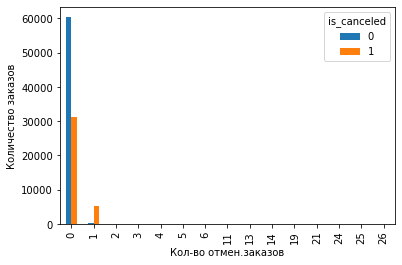

In [64]:
%matplotlib inline
pd.crosstab(df_all.previous_cancellations,df_all.is_canceled).plot(kind='bar')
plt.xlabel('Кол-во отмен.заказов')
plt.ylabel('Количество заказов')

* Необходимы места для парковки `required_car_parking_spaces`.

In [65]:
df_all.required_car_parking_spaces.unique()

array([0, 1, 2, 3, 8], dtype=int64)

In [66]:
pd.crosstab(df_all.required_car_parking_spaces,df_all.is_canceled)

is_canceled,0,1
required_car_parking_spaces,,
0,55695,36556
1,5134,0
2,17,0
3,2,0
8,2,0


Text(0, 0.5, 'Количество заказов')

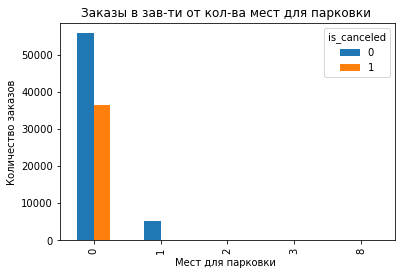

In [67]:
%matplotlib inline
pd.crosstab(df_all.required_car_parking_spaces,df_all.is_canceled).plot(kind='bar')
plt.title('Заказы в зав-ти от кол-ва мест для парковки ')
plt.xlabel('Мест для парковки ')
plt.ylabel('Количество заказов')

Практически для всех заказов не требуется парковочное место, для оставшихся, порядка 5 %, отказов нет. Следовательно нет и зависимости количества отказов от количества парковочных мест.
Уберем из итогового датафрейма.

* Тип комнаты`reserved_room_type`.

In [68]:
df_all.reserved_room_type.unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

Text(0, 0.5, 'Количество заказов')

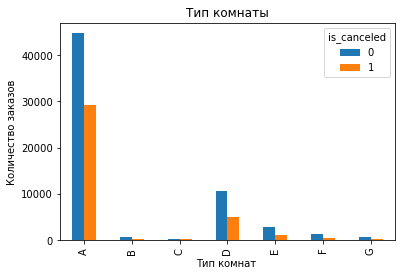

In [69]:
%matplotlib inline
pd.crosstab(df_all.reserved_room_type,df_all.is_canceled).plot(kind='bar')
plt.title('Тип комнаты')
plt.xlabel('Тип комнат ')
plt.ylabel('Количество заказов')

* Кол-во дней в будни`stays_in_week_nights`.

In [70]:
df_all.stays_in_week_nights.unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int64)

Text(0, 0.5, 'Количество заказов')

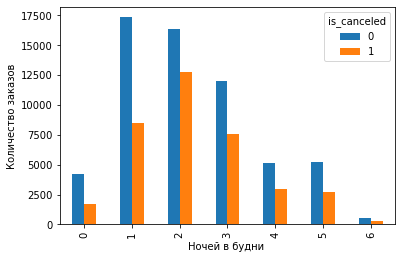

In [71]:
%matplotlib inline
pd.crosstab(df_all.stays_in_week_nights,df_all.is_canceled).plot(kind='bar')
plt.xlabel('Ночей в будни ')
plt.ylabel('Количество заказов')

* Кол-во дней в выходной`stays_in_weekend_nights`.

In [72]:
df_all.stays_in_weekend_nights.unique()

array([0, 2, 1, 4, 3], dtype=int64)

Text(0, 0.5, 'Количество заказов')

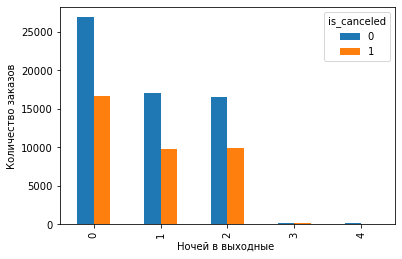

In [73]:
%matplotlib inline
pd.crosstab(df_all.stays_in_weekend_nights,df_all.is_canceled).plot(kind='bar')
plt.xlabel('Ночей в выходные ')
plt.ylabel('Количество заказов')

* Всего ночей `total_nights`.

In [74]:
df_all.total_nights.unique()

array([ 1,  2,  3,  4,  6,  7,  5,  8, 10,  9], dtype=int64)

Text(0, 0.5, 'Количество заказов')

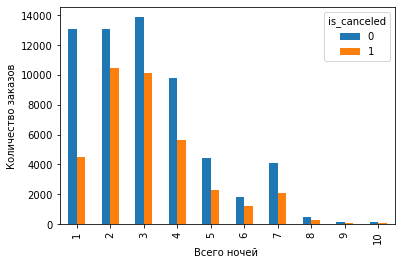

In [75]:
%matplotlib inline
pd.crosstab(df_all.total_nights,df_all.is_canceled).plot(kind='bar')
plt.xlabel('Всего ночей ')
plt.ylabel('Количество заказов')

In [76]:
df_all[['total_nights','stays_in_weekend_nights','stays_in_week_nights']].sample(5)

,total_nights,stays_in_weekend_nights,stays_in_week_nights
81780,2,0,2
32523,2,0,2
78590,3,1,2
94294,1,1,0
28071,3,0,3


In [77]:
df_all.query('total_nights != stays_in_weekend_nights + stays_in_week_nights')

,adults,arrival_date_day_of_month,arrival_date_month,arrival_date_week_number,arrival_date_year,babies,booking_changes,children,country,customer_type,days_in_waiting_list,distribution_channel,is_canceled,is_repeated_guest,lead_time,meal,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,reserved_room_type,stays_in_week_nights,stays_in_weekend_nights,total_nights,total_of_special_requests


* Кол-во спец. отметок `total_of_special_requests`.

In [78]:
df_all.total_of_special_requests.unique()

array([0, 1, 3, 2, 4, 5], dtype=int64)

Text(0, 0.5, 'Количество заказов')

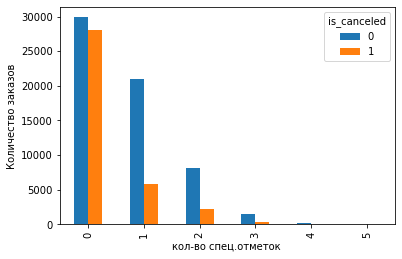

In [79]:
%matplotlib inline
pd.crosstab(df_all.total_of_special_requests,df_all.is_canceled).plot(kind='bar')
plt.title('')
plt.xlabel('кол-во спец.отметок ')
plt.ylabel('Количество заказов')

In [80]:
df_all[['arrival_date_year','arrival_date_month']][65229:].value_counts()

arrival_date_year  arrival_date_month
2017               spring                14386
                   summer                11277
                   winter                 6514
dtype: int64

уберем этот столбец из итогового датафрейма.

**Итоговый датафрейм:**

**В первой итерации были оставлены эти колонки, но качество модели получалось плохое. С использованием модели прибыль становилась даже меньше, чем без нее.**<br>
 `df_all = df_all[['adults', 'arrival_date_month', 'country', 'customer_type', 'distribution_channel', 
                'is_canceled', 'is_repeated_guest', 'meal', 'previous_bookings_not_canceled', 
               'previous_cancellations', 'required_car_parking_spaces', 
              'reserved_room_type', 'total_nights']]`

В итоге оставляем данные колонки.

In [81]:
df_all = df_all[['arrival_date_month', 'country', 'customer_type', 'distribution_channel', 
                'is_canceled', 'meal', 'reserved_room_type', 'total_nights']]

In [82]:
# для подсчета прибыли без модели
df_all_copy = df_all.copy(deep = True)

In [83]:
df_train_copy, df_test_copy = divide_df(df_all_copy)

In [84]:
print(f'Размерность объединенного датафрейма{df_all_copy.shape}\n')
print(f'Размерность тренировочного датафрейма{df_train_copy.shape}\n')
print(f'Размерность тестового датафрейма{df_test_copy.shape}')

Размерность объединенного датафрейма(97406, 8)

Размерность тренировочного датафрейма(65063, 8)

Размерность тестового датафрейма(32343, 8)


### Подсчет прибыли без учета депозитов.

#### Добавим два столбца со стоимостью номера и обслуживания в зависимости от типа номера.

In [85]:
df_test_copy['night_price'] = np.select([df_test_copy['reserved_room_type'] =='A', df_test_copy['reserved_room_type'] == 'B',
                                  df_test_copy['reserved_room_type'] == 'C', df_test_copy['reserved_room_type'] == 'D',
                                  df_test_copy['reserved_room_type'] == 'E', ['reserved_room_type'] == 'F', 
                                  df_test_copy['reserved_room_type'] == 'G'],[1000,800,600,550,500,450,350])

df_test_copy['service'] = np.select([df_test_copy['reserved_room_type'] =='A', df_test_copy['reserved_room_type'] == 'B',
                                  df_test_copy['reserved_room_type'] == 'C',df_test_copy['reserved_room_type'] == 'D',
                                  df_test_copy['reserved_room_type'] == 'E', ['reserved_room_type'] == 'F', 
                                  df_test_copy['reserved_room_type'] == 'G'],[400,350,350,150,150,150,150])

In [86]:
df_test_copy[['reserved_room_type', 'arrival_date_month', 'night_price']].head()

,reserved_room_type,arrival_date_month,night_price
65229,A,winter,1000
65230,A,winter,1000
65231,A,winter,1000
65232,A,winter,1000
65233,A,winter,1000


#### Учет сезонного коэффициента в стоимости .

In [87]:
df_test_copy.loc[df_test_copy['arrival_date_month'] == 'summer','night_price'] = df_test_copy['night_price'] * 1.4 

df_test_copy.loc[(df_test_copy['arrival_date_month'] == 'spring') | (df_test_copy['arrival_date_month'] == 'autumn'), 
                 'night_price'] = df_test_copy['night_price'] * 1.2 

In [88]:
df_test_copy[['reserved_room_type', 'arrival_date_month', 'night_price']].head()

,reserved_room_type,arrival_date_month,night_price
65229,A,winter,1000.0
65230,A,winter,1000.0
65231,A,winter,1000.0
65232,A,winter,1000.0
65233,A,winter,1000.0


In [89]:
# потребуется для подсчета прибыли после обучения модели
df_test_copy_1 = df_test_copy.copy(deep = True)

## Считаем прибыль.<br>
Так как при бронировании на длительный период номер убирают раз в два дня, то при подсчете прибыли будем учитаывть этот момент. Длительное бронировании примем - больше 2 дней.

##### Прибыль с заказа отель получит если `is_canceled=0`, убыток если `is_canceled=1`.

#### Выделим данные только из тех, кто не отменил заказ .

In [90]:
df_test_copy_prof = df_test_copy[df_test_copy['is_canceled'] == 0]

#### Прибыль будет равна стоимости проживания минус расходы на обслуживание, с учетем количества дней проживания.

In [91]:
df_test_copy_prof.loc[(df_test_copy_prof['total_nights'] < 2) | (df_test_copy_prof['total_nights'] == 2),'profit'] = \
df_test_copy_prof['total_nights'] * df_test_copy_prof['night_price'] - (
    ((df_test_copy_prof['total_nights'] // 2) + 1)*df_test_copy_prof['service']) 

df_test_copy_prof.loc[df_test_copy_prof['total_nights'] > 2,'profit'] = \
df_test_copy_prof['total_nights'] * df_test_copy_prof['night_price']  - (
    ((df_test_copy_prof['total_nights'] // 2) + 1)*df_test_copy_prof['service'])

#### Посчитаем убытки при отмене брони.

In [92]:
df_test_copy_waste = df_test_copy[df_test_copy['is_canceled'] == 1]

In [93]:
df_test_copy_waste['waste'] = df_test_copy_waste ['night_price'] + df_test_copy_waste ['service'] 

In [94]:
profit_1 = (df_test_copy_prof["profit"].sum()) - (df_test_copy_waste["waste"].sum())

In [95]:
print(f'Доход за год: {df_test_copy_prof["profit"].sum()}, руб.')
print(f'Убыток за год: {df_test_copy_waste["waste"].sum()}, руб.')
print(f'Прибыль за год: {profit_1}, руб.')

Доход за год: 50014770.0, руб.
Убыток за год: 17886680.0, руб.
Прибыль за год: 32128090.0, руб.


### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес-метрика для любой сети отелей — её прибыль. Максимальная прибыль будет если модель предскажет наибольшее количество отменяющих бронь людей. При этом количетсво людей, которое не отменило бронь, но в результате прогноза оказалось в списке отменивших, должно быть минимально.<br> 
Выберем ML- метрику `Recall_score` для оценки качества модели.

### Шаг 4. Разработка модели ML

#### Подготовка признаков

**Категориальные переменные.**

In [96]:
df_all = df_all[['arrival_date_month', 'country', 'customer_type', 'distribution_channel', 
                'is_canceled', 'meal', 'reserved_room_type', 'total_nights']]

`OHE` кодирование:

In [97]:
df_all = pd.get_dummies(df_all, drop_first=True)

In [98]:
df_all.head()

,is_canceled,total_nights,arrival_date_month_spring,arrival_date_month_summer,arrival_date_month_winter,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,meal_FB,meal_HB,meal_SC,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G
0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [99]:
df_train, df_test = divide_df(df_all)

* Задаем целевой признак и признаки для прогноза для выборок.

In [100]:
X_train = df_train.drop('is_canceled',axis = 1)
y_train = df_train['is_canceled']
X_test = df_test.drop('is_canceled',axis = 1)
y_test = df_test['is_canceled']

**Проверка диссбаланса классов.**

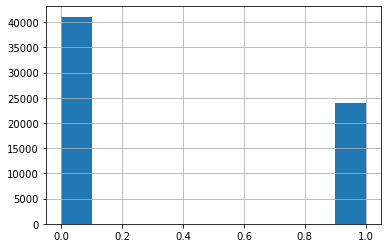

In [101]:
y_train.hist();

In [102]:
smote = SMOTE(random_state=42)

In [103]:
X_train, y_train = smote.fit_resample(X_train, y_train)

<AxesSubplot:>

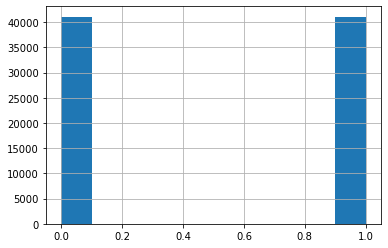

In [104]:
y_train.hist()

### Модель `RandomForestClassifier`

In [105]:
model_1 = RandomForestClassifier()
parametrs = {'max_depth' : range(2,20,5), 'n_estimators' : range(2,100,10)}
grid_rf = GridSearchCV(model_1, parametrs, cv = 5, scoring = 'recall')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 20, 5),
                         'n_estimators': range(2, 100, 10)},
             scoring='recall')

In [106]:
best_model_1 = grid_rf.best_estimator_

In [107]:
grid_rf.best_score_

0.7938504525434935

In [108]:
print(f'Recall для Random Forest:{grid_rf.best_score_}')

Recall для Random Forest:0.7938504525434935


### Модель `LogisticRegression`

In [109]:
model_2 = LogisticRegression()
parametrs = {'solver':['lbfgs', 'liblinear']}
grid_lr = GridSearchCV(model_2, parametrs, cv = 5, scoring = 'recall')
grid_lr.fit(X_train, y_train)

C:\Users\pulka\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pulka\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'solver': ['lbfgs', 'liblinear']}, scoring='recall')

In [110]:
best_model_2 = grid_lr.best_estimator_

In [111]:
grid_lr.best_score_

0.7099100551777752

In [112]:
print(f'Recall для Logistic Regression:{grid_lr.best_score_}')

Recall для Logistic Regression:0.7099100551777752


#### Выбираем модель Random Forest.

**Считаем метрику и прибывь на тестовой выборке.**

In [113]:
y_pred_1 = best_model_1.predict(X_test)
print(recall_score(y_test, y_pred_1))

0.9693471337579618


In [114]:
best_features = pd.Series(best_model_1.feature_importances_,
                         df_test.drop(['is_canceled'], axis=1).columns)

In [115]:
best_features.sort_values(ascending = False)

country_CHE                  0.378296
country_AUT                  0.330417
country_FIN                  0.163557
country_DNK                  0.121563
arrival_date_month_spring    0.006026
                               ...   
country_GUY                  0.000000
country_HKG                  0.000000
country_HND                  0.000000
country_HRV                  0.000000
reserved_room_type_G         0.000000
Length: 192, dtype: float64

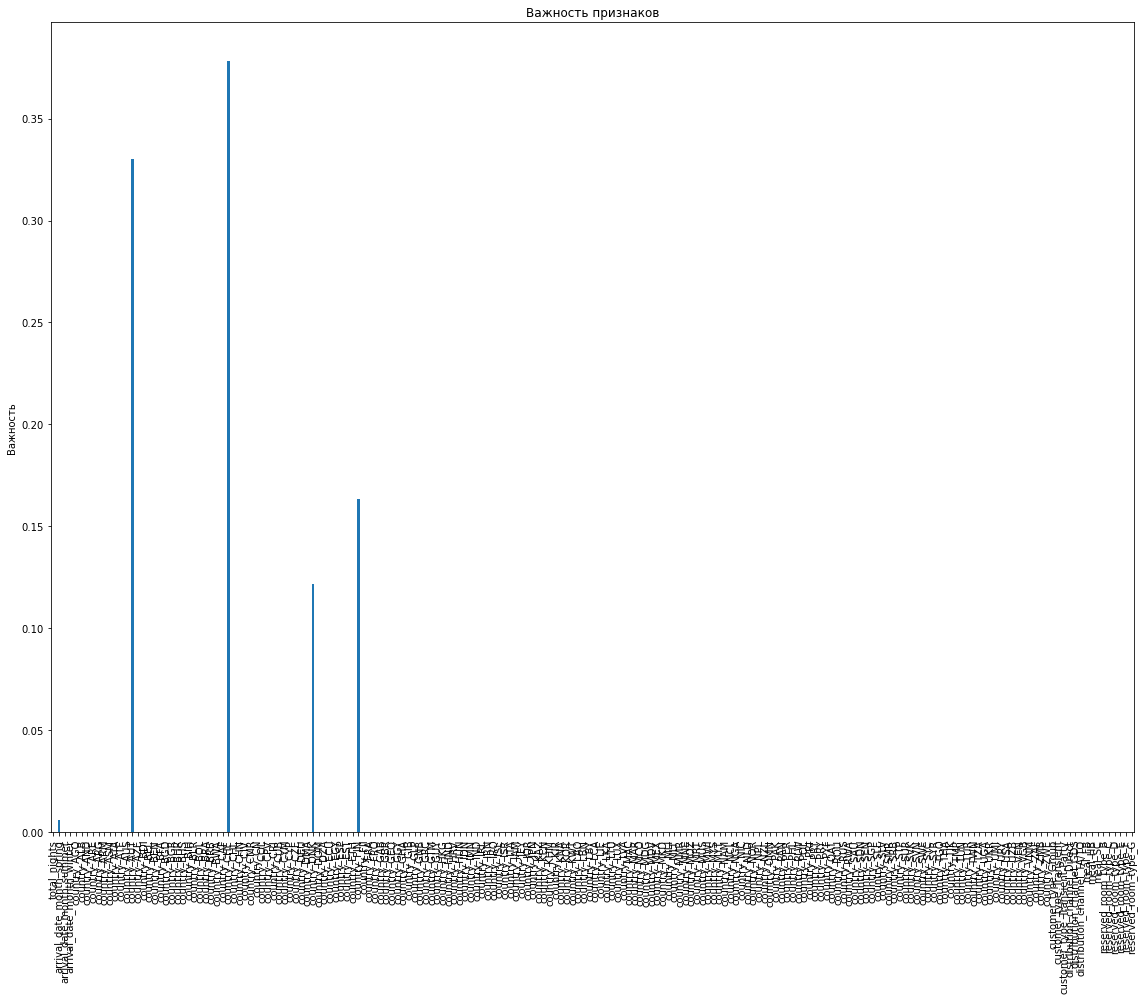

In [116]:
fig, ax = plt.subplots(figsize=(16,14))
best_features.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

### Подсчет прибыли от использования модели.

Возможные варианты:

is_canceled = 0, predictions = 0 — постоялец заселился (profit > 0), модель предсказала, что он заселится. В этом случае прибыль отеля никак не меняется
    
is_canceled = 0, predictions = 1 — постоялец заселился (profit > 0), модель предсказала, что он отменит. В этом случае постоялец внесёт депозит, который пойдёт в счёт оплаты, то есть в этом случае прибыль отеля тоже никак не меняется.
    
is_canceled = 1, predictions = 0 — постоялец отменил бронь (profit < 0), модель предсказала, что он заселится, то есть депозит с такого клиента не брали. Тогда прибыль отеля тоже никак не меняется, отель просто потерял деньги, как и до внедрения модели.
                                                                        
is_canceled = 1, predictions = 1 — постоялец отменил бронь (profit < 0), модель предсказала, что он отменит, с постояльца взяли депозит в 80% от стоимости номера за одни сутки с учетом сезонного коэффициента и затрат на разовую уборку, отель потеряет только 20% от той суммы, которую терял без модели, так как остальное покроет депозит

In [117]:
y_pred_1 = pd.Series(y_pred_1).reset_index(drop = True)
df_test_copy_1 = df_test_copy_1.reset_index(drop = True)

In [118]:
df_test_copy_1['pred'] = y_pred_1

In [119]:
df_test_copy_prof = df_test_copy_1[(df_test_copy_1['pred'] == 1) & (df_test_copy_1['is_canceled'] == 1)]

In [120]:
df_test_copy_prof['deposit'] = df_test_copy_prof['night_price'] * 0.8 + df_test_copy_prof['service'] * 0.8 

In [121]:
profit_model = df_test_copy_prof['deposit'].sum() - BUDJET

In [122]:
print(f'Выигрыш в прибыли от модели {profit_model}')

Выигрыш в прибыли от модели 13505968.0


### Шаг 5. Опишите портрет «ненадёжного» клиента

Text(0, 0.5, 'Количество заказов')

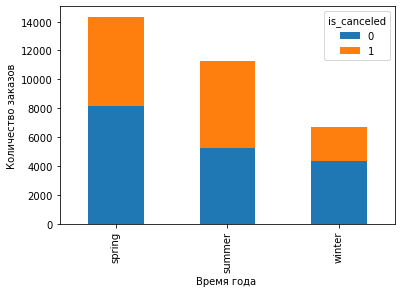

In [123]:
%matplotlib inline
pd.crosstab(df_test_copy_1.arrival_date_month,df_all.is_canceled).plot(kind='bar', stacked=True)
plt.xlabel('Время года ')
plt.ylabel('Количество заказов')

In [124]:
pd.crosstab(df_test_copy_1.arrival_date_month,df_all.is_canceled)

is_canceled,0,1
arrival_date_month,,
spring,8134,6213
summer,5221,6024
winter,4363,2317


Чаще всего отказывались от брони летом (`summer`).

Text(0, 0.5, 'Количество заказов')

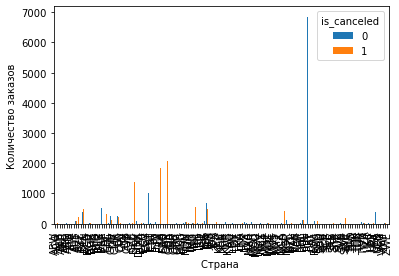

In [125]:
%matplotlib inline
pd.crosstab(df_test_copy_1.country,df_all.is_canceled).plot(kind='bar')
plt.xlabel('Страна ')
plt.ylabel('Количество заказов')

In [126]:
new = pd.crosstab(df_test_copy_1.country, df_all.is_canceled).reset_index()

In [127]:
new.sort_values(by = 1, ascending = False)

is_canceled,country,0,1
108,PRT,6853,3022
48,GBR,1827,2087
45,FRA,1630,1828
34,DEU,991,1374
40,ESP,1002,921
...,...,...,...
39,EGY,3,0
78,LIE,1,0
49,GHA,2,0
51,GNB,1,0


Больше всего отказываются от брони  из стран `GBR`, `FRA`.

Text(0, 0.5, 'Количество заказов')

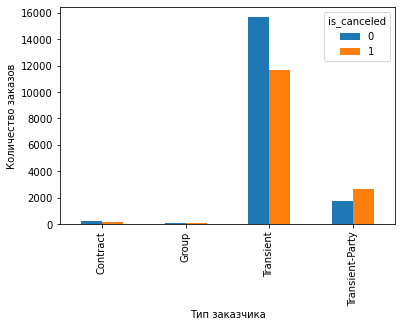

In [128]:
%matplotlib inline
pd.crosstab(df_test_copy_1.customer_type,df_all.is_canceled).plot(kind='bar')
plt.xlabel('Тип заказчика')
plt.ylabel('Количество заказов')

In [129]:
pd.crosstab(df_test_copy_1.customer_type,df_all.is_canceled)

is_canceled,0,1
customer_type,,
Contract,195,164
Group,64,101
Transient,15678,11659
Transient-Party,1781,2630


Больше всего отказываются от брони  типы заказчиков`Transient-Party	`.

Text(0, 0.5, 'Количество заказов')

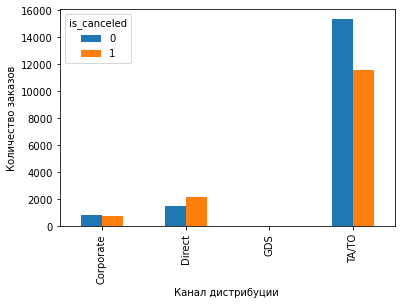

In [130]:
%matplotlib inline
pd.crosstab(df_test_copy_1.distribution_channel,df_all.is_canceled).plot(kind='bar')
plt.xlabel('Канал дистрибуции ')
plt.ylabel('Количество заказов')

In [131]:
pd.crosstab(df_test_copy_1.distribution_channel,df_all.is_canceled)

is_canceled,0,1
distribution_channel,,
Corporate,829,771
Direct,1483,2142
GDS,53,32
TA/TO,15353,11609


Больше всего отказываются от брони  при канале дистрибуции `Direct`.

Text(0, 0.5, 'Количество заказов')

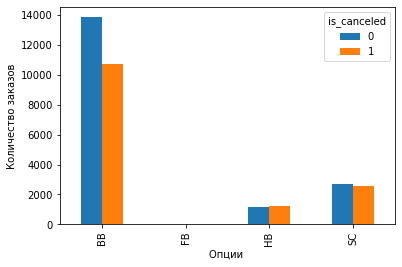

In [132]:
%matplotlib inline
pd.crosstab(df_test_copy_1.meal,df_all.is_canceled).plot(kind='bar')
plt.xlabel('Опции ')
plt.ylabel('Количество заказов')

In [133]:
pd.crosstab(df_test_copy_1.meal,df_all.is_canceled)

is_canceled,0,1
meal,,
BB,13832,10746
FB,25,11
HB,1143,1252
SC,2718,2545


Больше всего отказываются от брони при опциях `HB`.

Text(0, 0.5, 'Количество заказов')

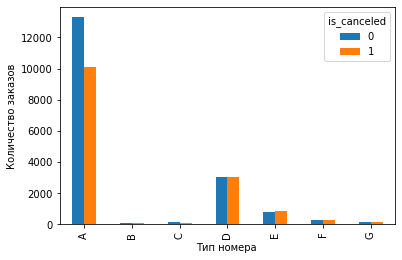

In [134]:
%matplotlib inline
pd.crosstab(df_test_copy_1.reserved_room_type,df_all.is_canceled).plot(kind='bar')
plt.xlabel('Тип номера ')
plt.ylabel('Количество заказов')

In [135]:
pd.crosstab(df_test_copy_1.reserved_room_type,df_all.is_canceled)

is_canceled,0,1
reserved_room_type,,
A,13317,10090
B,68,68
C,115,86
D,3057,3048
E,791,851
F,252,251
G,118,160


Больше всего отказываются от брони при типе номера `Е`.

Text(0, 0.5, 'Количество заказов')

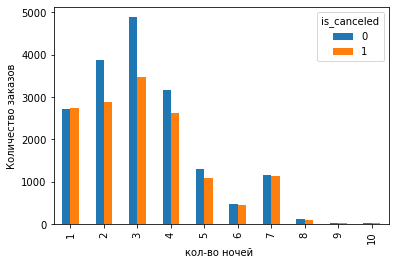

In [136]:
%matplotlib inline
pd.crosstab(df_test_copy_1.total_nights,df_all.is_canceled).plot(kind='bar')
plt.title('')
plt.xlabel('кол-во ночей ')
plt.ylabel('Количество заказов')

In [137]:
pd.crosstab(df_test_copy_1.total_nights,df_all.is_canceled)

is_canceled,0,1
total_nights,,
1,2706,2737
2,3865,2878
3,4887,3469
4,3165,2630
5,1298,1097
6,478,456
7,1146,1131
8,117,95
9,27,35


Больше всего отказываются от брони при количестве ночей - 1.

### Шаг 6. Напишите общий вывод

По результатам работы была построена модель по определению отказа от брони. Тип модели - RandomForestClassifier.
Модель позволяет отелю увеличить прибыль даже с учетом расходов на создание модели.

In [138]:
print(f'Прибыль без модели: {profit_1}')
print(f'Бюджет модели: {BUDJET}')
print(f'Выигрыш в прибыли от модели {profit_model}')

Прибыль без модели: 32128090.0
Бюджет модели: 400000.0
Выигрыш в прибыли от модели 13505968.0


Чаще всего отказывались от брони  клиенты со следующими признаками:
 - время года `summer` (месяца: июнь, июль, август).
 - тип заказчиков `Transient-Party`.
 - количестве ночей - 1.
 - тип номера `Е`.
 - опции `HB`.
 - канал дистрибуции `Direct`.
 - тип заказчика `Transient-Party`.
 - страны `GBR`, `FRA`.